In [11]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')
pd.set_option("display.max_rows", 100)

In [3]:
data = pd.read_csv("../input/pulsar_stars.csv")
data.columns = ['mean_ip', 'sd_ip', 'ek_ip', 'skw_ip', 'mean_dm', 'sd_dm', 'ek_dm', 'skw_dm', 'pulsar']
data.head()

,mean_ip,sd_ip,ek_ip,skw_ip,mean_dm,sd_dm,ek_dm,skw_dm,pulsar
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
data.describe()

,mean_ip,sd_ip,ek_ip,skw_ip,mean_dm,sd_dm,ek_dm,skw_dm,pulsar
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


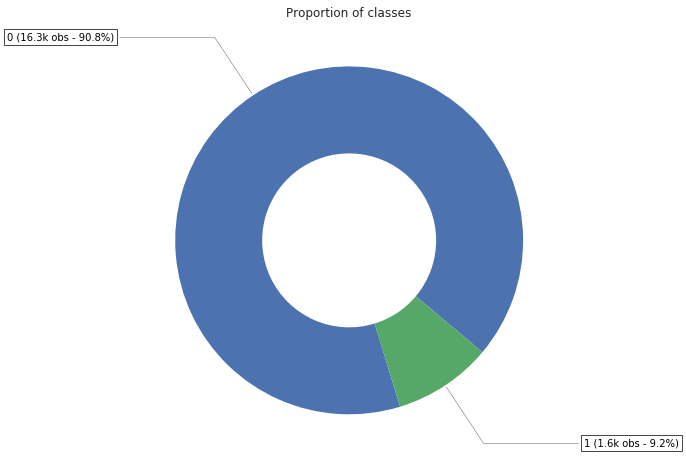

In [23]:
def donut_chart(data):
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(aspect="equal"))

    recipe = [str(i) for i in list(data.value_counts().index)]

    info = data.value_counts()

    def pcts(val_list):
        pct = []
        for val in val_list:
            pct.append(" ({:.1f}k obs - {:.1f}%)".format(val/1000, 100*val/np.sum(val_list)))
        return pct

    recipe2 = pcts(info)

    wedges, texts = ax.pie(info, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        kw["color"] = 'k'
        ax.annotate(recipe[i]+recipe2[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)

    ax.set_title("Proportion of classes")
    plt.show()
    
donut_chart(data['pulsar'])

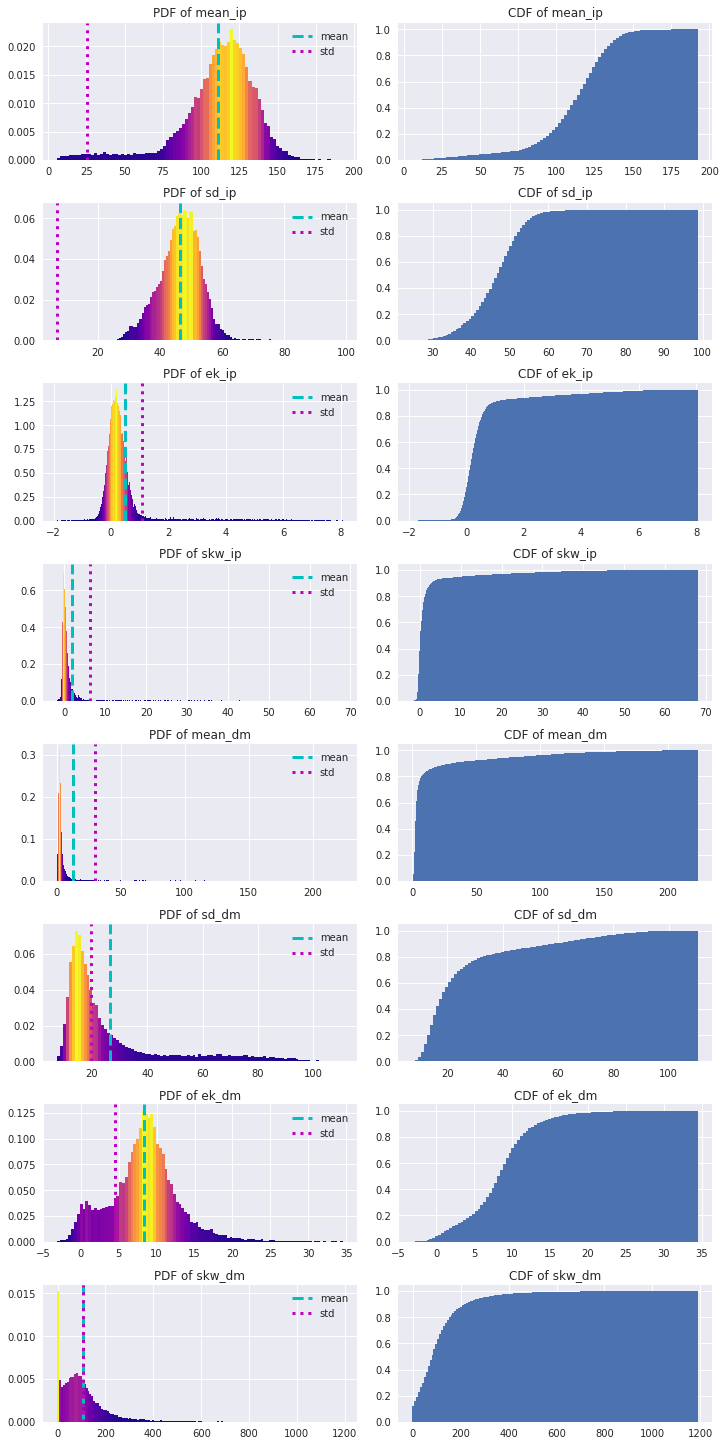

In [24]:
from matplotlib import colors

preds = [col for col in data.columns if col != "pulsar"]
num_preds = len(preds)
fig, axes = plt.subplots(num_preds, 2, figsize=(10,20))

for i, j in itertools.zip_longest(preds, range(num_preds)):
    N, bins, patches = axes[j, 0].hist(data[i], bins="auto", density=True)
    axes[j, 0].set_title(f"PDF of {i}")
    
    axes[j, 0].axvline(data[i].mean(), color = "c", linestyle="dashed", label="mean", linewidth=3)
    axes[j, 0].axvline(data[i].std(), color = "m", linestyle="dotted", label="std", linewidth=3)
    axes[j, 0].legend(("mean", "std"), loc="best")
    
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.plasma(norm(thisfrac))
        thispatch.set_facecolor(color)
    
    axes[j, 1].hist(data[i], bins="auto", cumulative=True, density=True)
    axes[j, 1].set_title(f"CDF of {i}")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

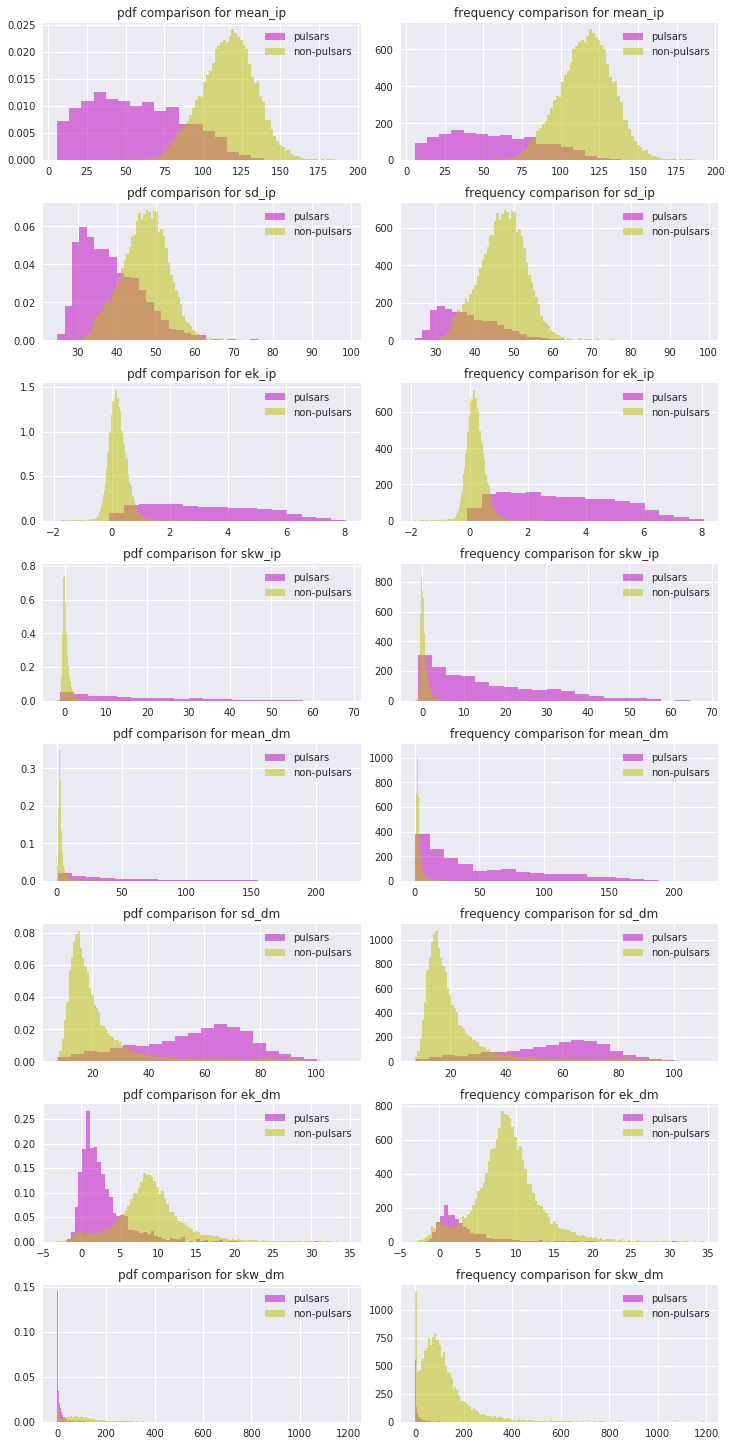

In [25]:
pulsars = data[data['pulsar'] == 1].drop('pulsar', axis=1)
non_pul = data[data['pulsar'] == 0].drop('pulsar', axis=1)

fig, axes = plt.subplots(num_preds, 2, figsize=(10,20))

for i, j in itertools.zip_longest(preds, range(num_preds)):
    axes[j, 0].hist(pulsars[i], bins="auto", label="pulsars", color = "m", alpha=0.5, density=True)
    axes[j, 0].hist(non_pul[i], bins="auto", label="non-pulsars", color = "y", alpha=0.5, density=True)
    axes[j, 0].set_title(f'PDF comparison for {i}')
    axes[j, 0].legend(loc="best")
    
    axes[j, 1].hist(pulsars[i], bins="auto", label="pulsars", color = "m", alpha=0.5)
    axes[j, 1].hist(non_pul[i], bins="auto", label="non-pulsars", color = "y", alpha=0.5)
    axes[j, 1].set_title(f'Frequency comparison for {i}')
    axes[j, 1].legend(loc="best")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

/home/andres-zarta/anaconda3/envs/tensor/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/andres-zarta/anaconda3/envs/tensor/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/andres-zarta/anaconda3/envs/tensor/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/andres-zarta/anaconda3/envs/tensor/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encounte

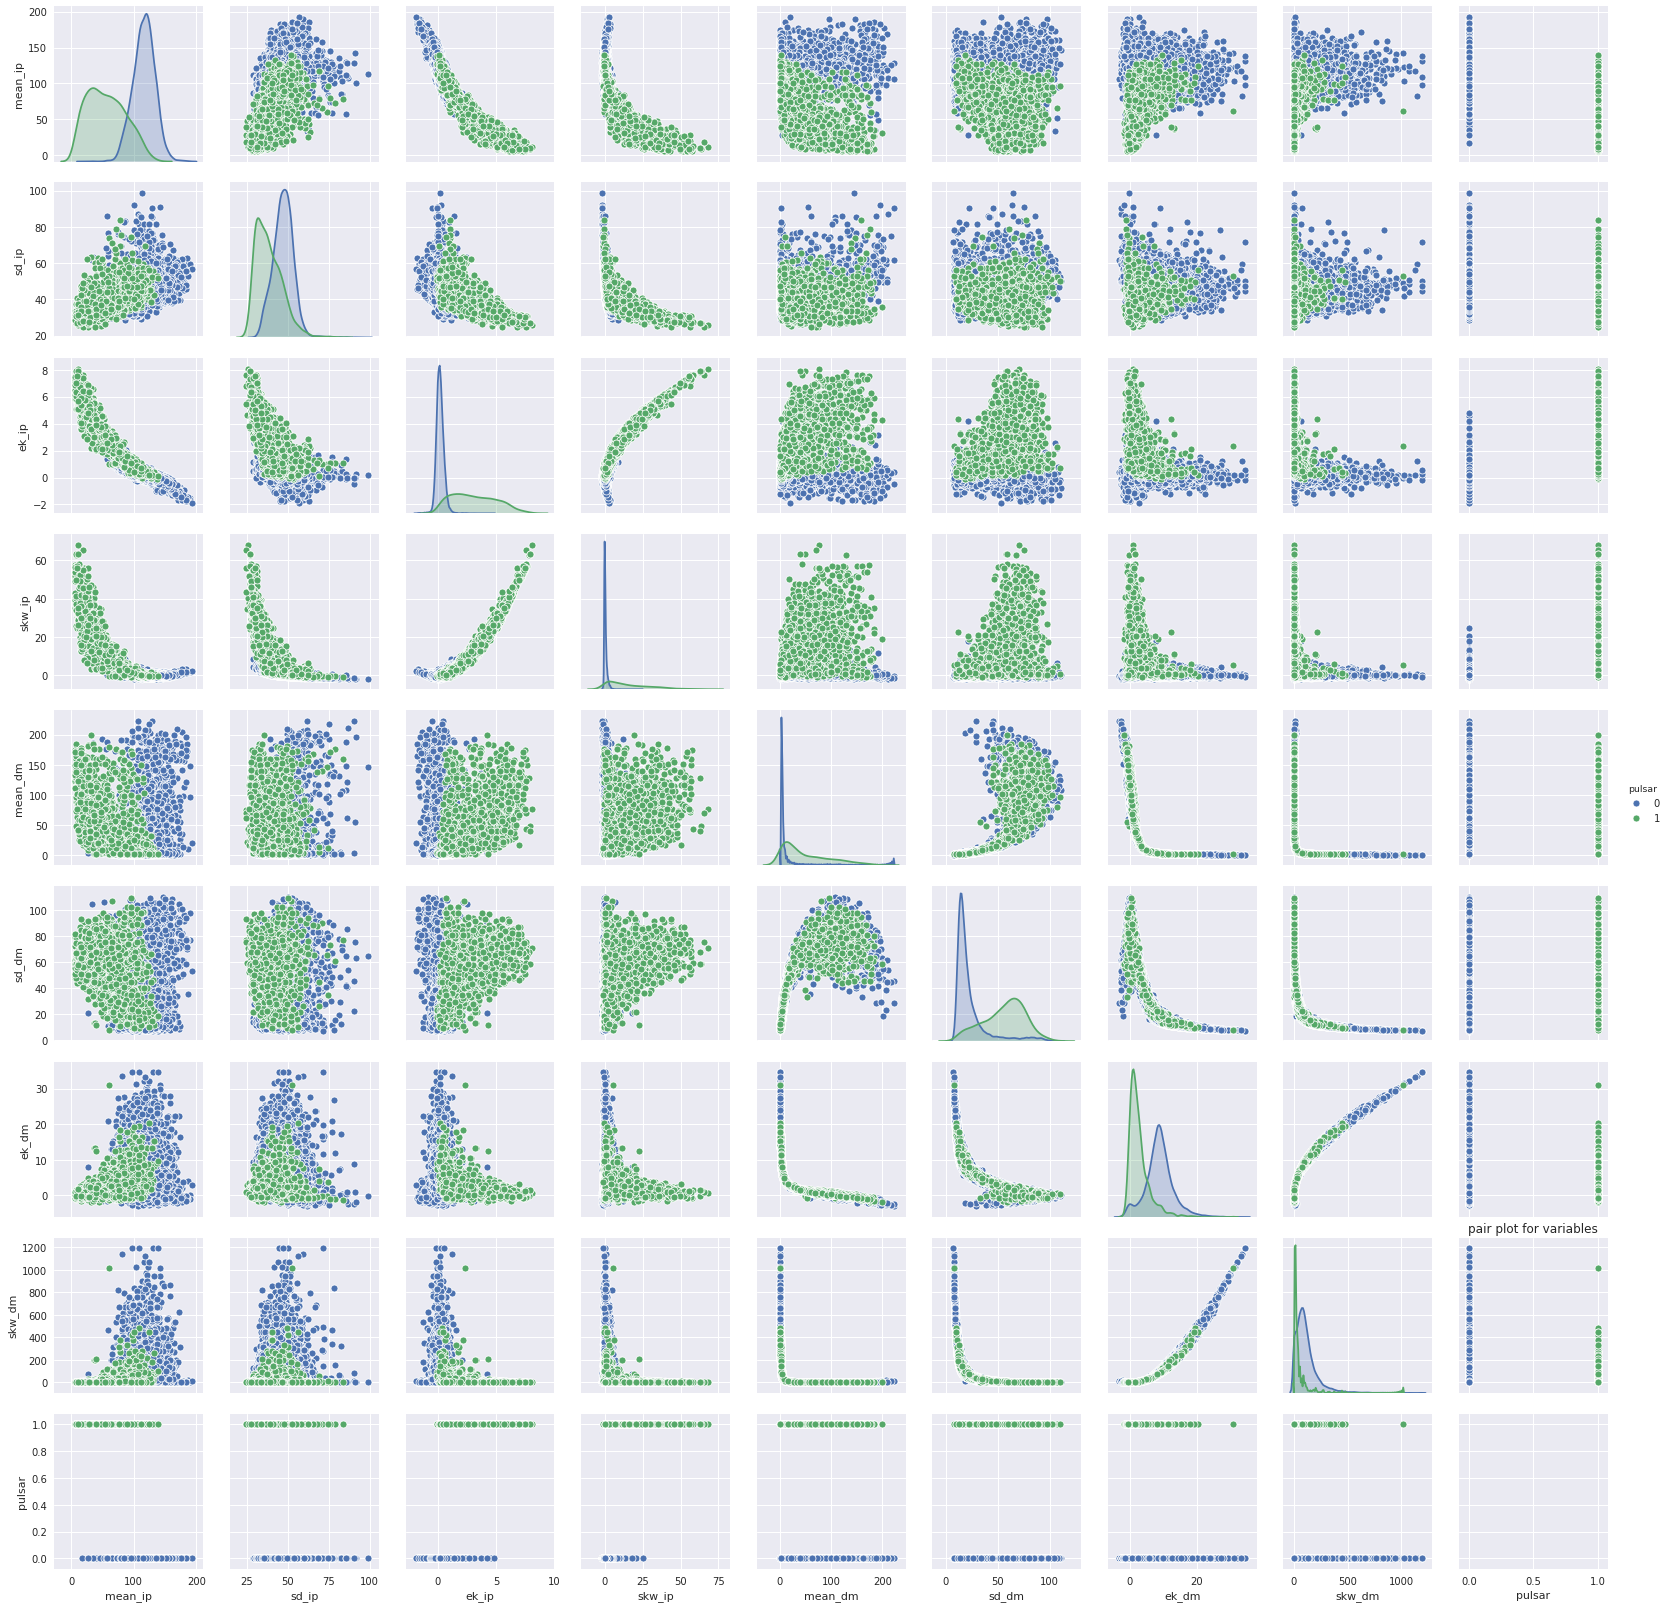

In [26]:
sns.pairplot(data,hue="pulsar")
plt.title("pair plot for variables")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(data,annot=True,
            cmap=sns.color_palette("pastel"),
            linewidth=2,edgecolor="k")
plt.title("CORRELATION BETWEEN VARIABLES")
plt.show()

/home/andres-zarta/anaconda3/envs/tensor/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


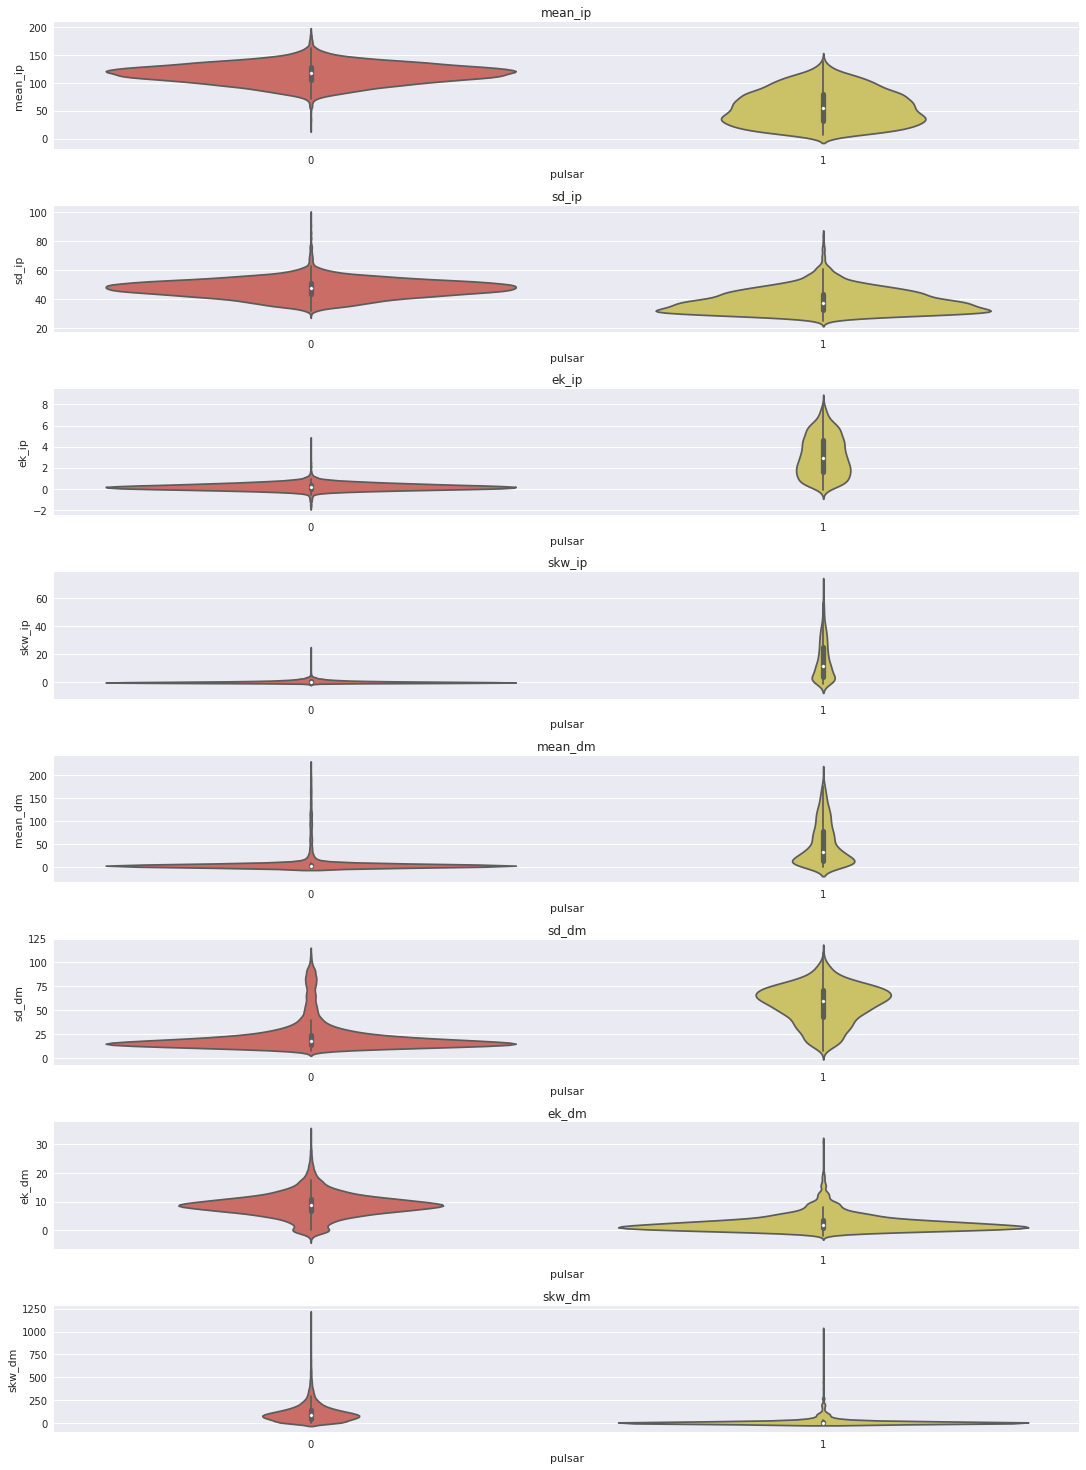

In [28]:
plt.figure(figsize=(15,25))

for i in range(num_preds):
    plt.subplot(10,1,i+1)
    sns.violinplot(x=data['pulsar'],y=data.iloc[:, i],
                   palette=sns.color_palette("hls", 7),alpha=.5)
    plt.title(data.columns[i])
    
plt.tight_layout()
plt.show()

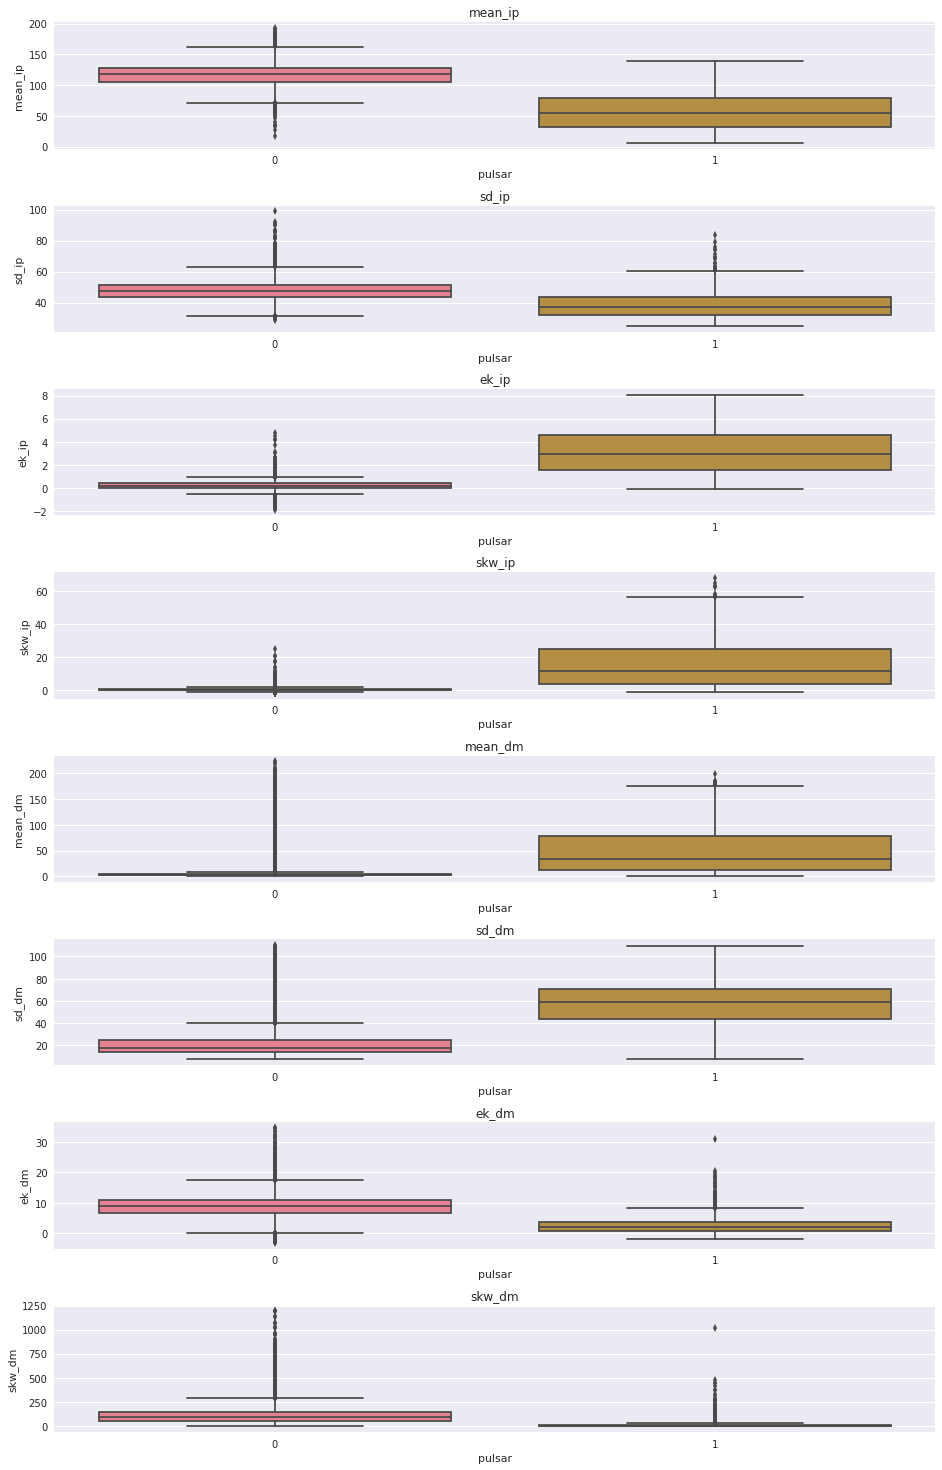

In [29]:
plt.figure(figsize=(13,25))

for i in range(num_preds):
    plt.subplot(10,1,i+1)
    sns.boxplot(data['pulsar'],y=data.iloc[:, i], 
                palette=sns.color_palette("husl", 7), color="w")
    plt.title(data.columns[i])
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [35]:
from sklearn.preprocessing import RobustScaler, StandardScaler

std_trans = StandardScaler().fit(data)
robust_trans = RobustScaler().fit(data)

/home/andres-zarta/anaconda3/envs/tensor/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [36]:
data2 = pd.DataFrame(robust_trans.transform(data), columns= ['mean_ip', 'sd_ip', 'ec_ip', 'sw_ip', 'mean_dm', 'sd_dm', 'ec_dm', 'sw_dm', 'pulsar'])
data3 = pd.DataFrame(std_trans.transform(data), columns= ['mean_ip', 'sd_ip', 'ec_ip', 'sw_ip', 'mean_dm', 'sd_dm', 'ec_dm', 'sw_dm', 'pulsar'])

/home/andres-zarta/anaconda3/envs/tensor/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [26]:
data2.describe()

,mean_ip,sd_ip,ec_ip,sw_ip,mean_dm,sd_dm,ec_dm,sw_dm,pulsar
count,17898.000000,1.789800e+04,1.789800e+04,1.789800e+04,17898.000000,1.789800e+04,1.789800e+04,17898.000000,17898.000000
mean,-0.152857,-4.602048e-02,5.706002e-01,1.407768e+00,2.770987,5.621705e-01,-2.640654e-02,0.208849,0.091574
std,0.980757,7.913778e-01,2.384525e+00,5.525048e+00,8.322905,1.391672e+00,9.156018e-01,1.020755,0.288432
min,-4.177419,-2.564469e+00,-4.704446e+00,-1.783122e+00,-0.731008,-7.927284e-01,-2.351497e+00,-0.814974,0.000000
25%,-0.540920,-5.286647e-01,-4.395563e-01,-3.469167e-01,-0.248155,-2.876170e-01,-5.388670e-01,-0.460993,0.000000
50%,0.000000,-4.108516e-16,3.110030e-17,-1.243275e-17,0.000000,1.269669e-16,1.804722e-16,0.000000,0.000000
75%,0.459080,4.713353e-01,5.604437e-01,6.530833e-01,0.751845,7.123830e-01,4.611330e-01,0.539007,0.000000
max,2.964456,5.994024e+00,1.758361e+01,6.082557e+01,62.292899,6.588692e+00,5.304597e+00,10.617621,1.000000


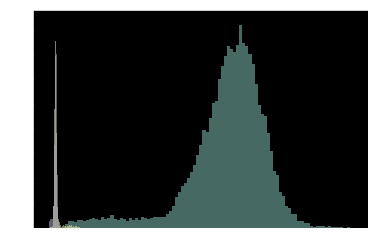

In [44]:
plt.hist(data['mean_ip'], bins='auto', alpha=0.5)
plt.hist(data2['ec_ip'], bins='auto', alpha=0.5)
plt.hist(data3['mean_ip'], bins='auto', alpha=0.5)
plt.show()

In [89]:
from sklearn.decomposition import PCA

data = pd.read_csv('/mnt/c/Users/Andres/Downloads/pulsar_stars.csv')
data.columns = ['mean_ip', 'sd_ip', 'ec_ip', 'sw_ip', 'mean_dm', 'sd_dm', 'ec_dm', 'sw_dm', 'pulsar']

data2 = pd.DataFrame(robust_trans.transform(data), columns= ['mean_ip', 'sd_ip', 'ec_ip', 'sw_ip', 'mean_dm', 'sd_dm', 'ec_dm', 'sw_dm', 'pulsar'])

pca = PCA(3)
preds = [col for col in data.columns if col != "pulsar"]
data2 = data2[preds]
print(data2.shape)
data2 = pca.fit_transform(data2)
print(data2.shape)

(17898, 8)
(17898, 3)


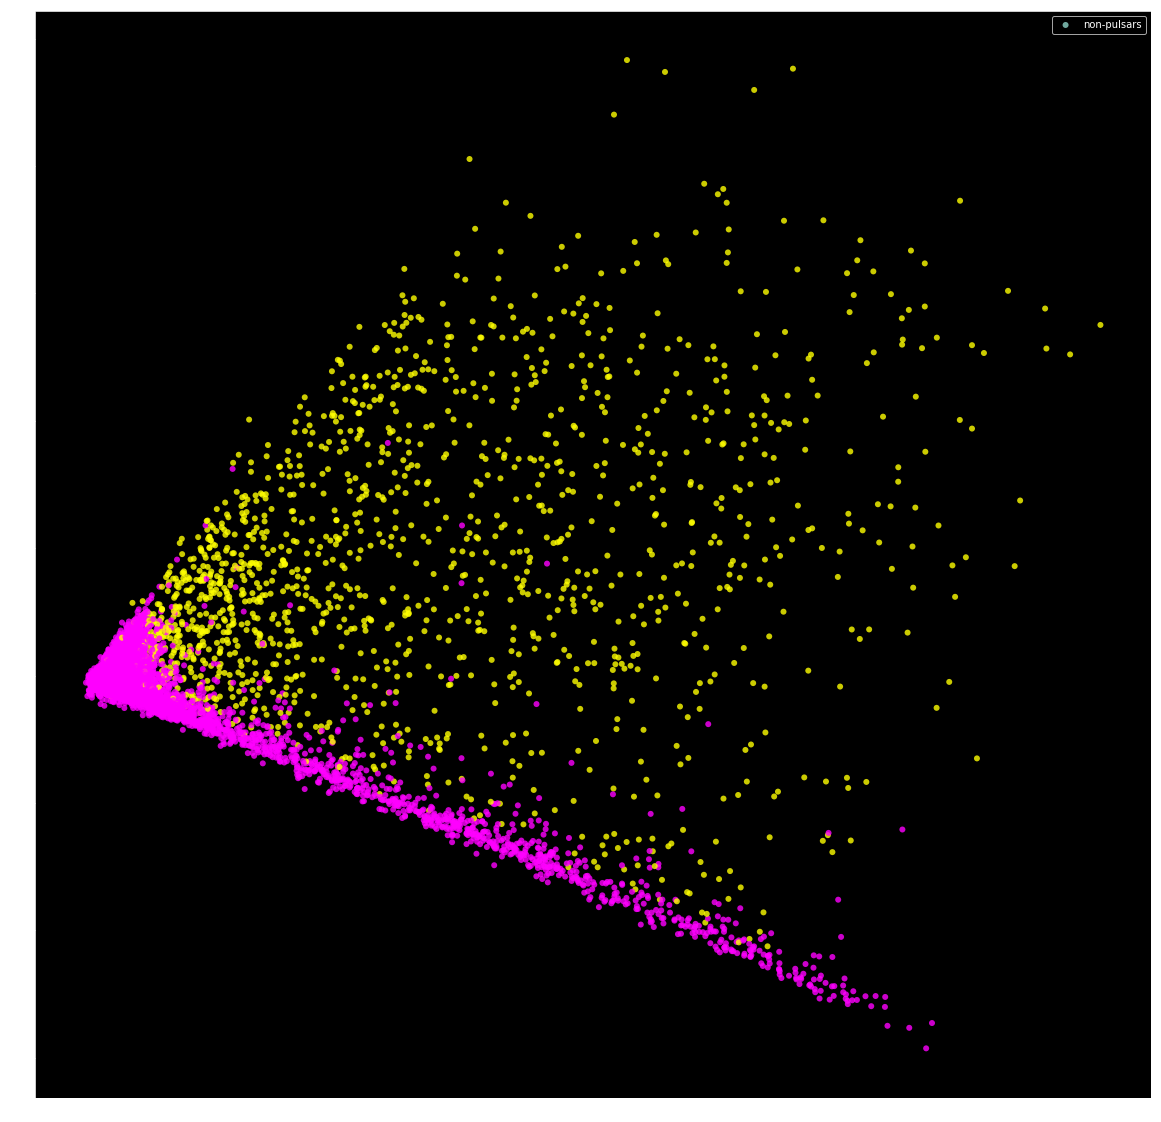

In [91]:
plt.figure(figsize=(20,20))

plt.scatter(data2[:,0], data2[:,1], c=data['pulsar'], 
            edgecolor='none', alpha=0.8,
            cmap=plt.get_cmap('spring', 10))
plt.legend(['non-pulsars', 'pulsars'])
plt.show()

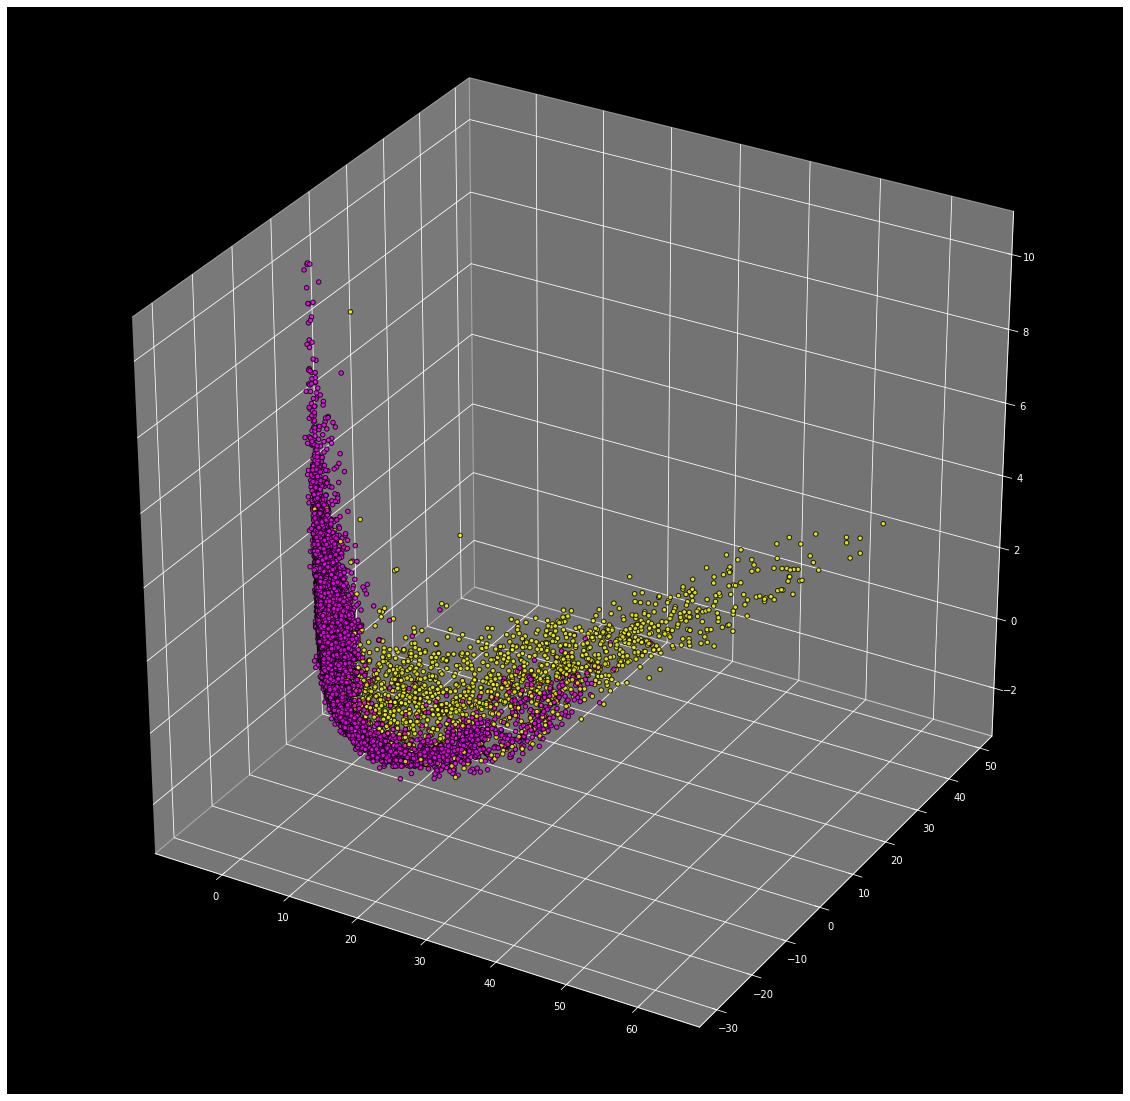

In [94]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data2[:,0], data2[:,1], data2[:,2], c=data['pulsar'], 
            edgecolor='none', alpha=0.8,
            cmap=plt.get_cmap('spring', 10))
plt.show()

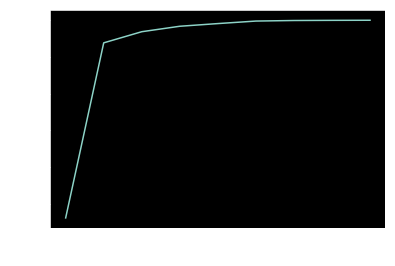

In [100]:
data = pd.read_csv('/mnt/c/Users/Andres/Downloads/pulsar_stars.csv')
data.columns = ['mean_ip', 'sd_ip', 'ec_ip', 'sw_ip', 'mean_dm', 'sd_dm', 'ec_dm', 'sw_dm', 'pulsar']

data2 = pd.DataFrame(robust_trans.transform(data), columns= ['mean_ip', 'sd_ip', 'ec_ip', 'sw_ip', 'mean_dm', 'sd_dm', 'ec_dm', 'sw_dm', 'pulsar'])


pca = PCA().fit(data2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [98]:
pca.explained_variance_ratio_

array([7.30467295e-01, 2.38720064e-01, 1.51775542e-02, 7.43808364e-03,
       3.64986214e-03, 3.43653623e-03, 7.50880935e-04, 2.25027101e-04,
       1.34697087e-04])

In [4]:
data.groupby('pulsar').size()

pulsar
0    16259
1     1639
dtype: int64

In [ ]:
data_gr = data.groupby('pulsar').mean()
data_gr.T.plot(kind="bar",width=.6,figsize=(13,6),colormap="Set3", logy=False)

In [ ]:
plt.pie(data['pulsar'].value_counts(), autopct='%.2f', labels=['non-pulsars', 'pulsars'], colors=['green', 'black'])
plt.show()

In [10]:
data = pd.DataFrame(RobustScaler().fit_transform(data))
data.describe()

,0,1,2,3,4,5,6,7,8
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,-0.152857,-0.046020,0.570600,1.407768,2.770987,0.562170,-0.026407,0.208849,0.091574
std,0.980757,0.791378,2.384525,5.525048,8.322905,1.391672,0.915602,1.020755,0.288432
min,-4.177419,-2.564469,-4.704446,-1.783122,-0.731008,-0.792728,-2.351497,-0.814974,0.000000
25%,-0.540920,-0.528665,-0.439556,-0.346917,-0.248155,-0.287617,-0.538867,-0.460993,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.459080,0.471335,0.560444,0.653083,0.751845,0.712383,0.461133,0.539007,0.000000
max,2.964456,5.994024,17.583609,60.825568,62.292899,6.588692,5.304597,10.617621,1.000000


In [ ]:
sns.pairplot(data,hue="pulsar")
plt.title("pair plot for variables")
plt.show()

In [30]:
        
def get_outliers(feature):
    data_out = data[feature]
    q1 = data_out.quantile(0.25)
    q3 = data_out.quantile(0.75)
    iqr = q3 - q1

    out_l = data_out[data_out < (q1 - 1.5*iqr)].index
    out_r = data_out[data_out > (q3 + 1.5*iqr)].index
    
    return(iqr, out_l, out_r)

In [31]:

def print_outlier_group():
    for i in preds:
        print(f'Predictor: {i}\n')

        iqr, out_l, out_r = get_outliers(i)

        full_count = pd.DataFrame()

        lower_count = data.iloc[out_l].groupby('pulsar').size().to_frame('lower_count')
        upper_count = data.iloc[out_r].groupby('pulsar').size().to_frame('upper_count')

        if not lower_count.empty:
            lower_count['lower_ratio'] = lower_count/lower_count.sum()
        else:
            lower_count['lower_ratio'] = np.nan
        if not upper_count.empty:
            upper_count['upper_ratio'] = upper_count/upper_count.sum()
        else:
            upper_count['upper_ratio'] = np.nan

        full_count = pd.concat([lower_count, upper_count], axis=1)
        print(full_count)
        print('\n======\n')

print_outlier_group()

Predictor: mean_ip

        lower_count  lower_ratio  upper_count  upper_ratio
pulsar                                                    
0                29     0.029683         53.0          1.0
1               948     0.970317          NaN          NaN


Predictor: sd_ip

        lower_count  lower_ratio  upper_count  upper_ratio
pulsar                                                    
0                 2     0.015625          123      0.91791
1               126     0.984375           11      0.08209


Predictor: ek_ip

        lower_count  lower_ratio  upper_count  upper_ratio
pulsar                                                    
0             113.0          1.0          126     0.084963
1               NaN          NaN         1357     0.915037


Predictor: skw_ip

        lower_count  lower_ratio  upper_count  upper_ratio
pulsar                                                    
0               NaN          NaN          589     0.309837
1               NaN          NaN  

count
1    1331
2    1730
3     350
4     338
5     717
6     112
dtype: int64


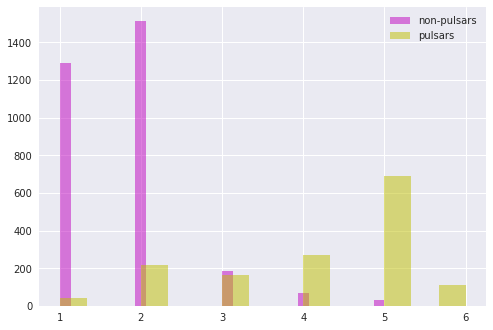

In [32]:
def update_outlier_dict(ou, out_list, label, i):
    for elem in list(out_list):
        if ou.get(elem) is None:
            ou.update({elem: dict.fromkeys(preds, None)})
        ou.get(elem).update({i: label})
        
def print_outliers_df():
    ou = {}
    for i in preds:
        iqr, out_l, out_r = get_outliers(i)
        
        update_outlier_dict(ou, out_l, "L", i)
        update_outlier_dict(ou, out_r, "R", i)

    df = pd.DataFrame.from_dict(ou, orient='index')
    df['count'] = df.count(axis=1)
    df['pulsar'] = data['pulsar'].iloc[df.index]
    #print(df.groupby('pulsar').size().to_frame('count_r'))
    #print(df.sort_values('count', ascending=False))
    print(df.groupby('count').size())
    plt.hist(df[df['pulsar']==0]['count'], bins='auto', color = "m", alpha=0.5)
    plt.hist(df[df['pulsar']==1]['count'], bins='auto', color = "y", alpha=0.5)
    plt.legend(labels=['non-pulsars', 'pulsars'])

print_outliers_df()

In [6]:
outliers_list = []
for p in preds:
    iqr, ll, lr = get_outliers(p)
    outliers_list = outliers_list + list(ll) + list(lr)

outliers_list = list(set(outliers_list))

data_no = data.drop(outliers_list, axis=0)
data_no = data_no.reset_index(drop=True)
print(len(data_no))

13320


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
X = data[preds]
y = data['pulsar']

sss = StratifiedShuffleSplit(test_size=0.33)
for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

#print(X_train)

In [ ]:
X = data[preds]
y = data['pulsar']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=420)



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn import metrics



logit = logit.fit(X_train, y_train)
y_pred_log = logit.predict(X_test)
scores = cross_val_score(logit, X, y,  scoring="balanced_accuracy", cv=5)
print("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

confusion_matrix_log = metrics.confusion_matrix(y_test,y_pred_log)
print(confusion_matrix_log)

auc_roc_log =metrics.roc_auc_score(y_test,y_pred_log)
print("auc score = {}".format(auc_roc_log))

bal_acc_log = metrics.balanced_accuracy_score(y_test, y_pred_log)
print("auc balanced_accuracy_score = {}".format(bal_acc_log))

for alfa in alphas:
    rge = RidgeClassifier(alpha=alfa, class_weight='balanced')
    rge = rge.fit(X_train, y_train)
    print(rge.get_params())
    y_pred_rge = rge.predict(X_test)
    #y_pred_rge = list(map(lambda x: 1 if x >= 0 else 0, y_pred_rge))

    confusion_matrix_rge = metrics.confusion_matrix(y_test,y_pred_rge)
    print(confusion_matrix_rge)

    auc_roc_rge =metrics.roc_auc_score(y_test,y_pred_rge)
    print("auc score = {}".format(auc_roc_rge))


fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_log)
plt.plot(fpr, tpr)

In [ ]:
from sklearn import linear_model

las = linear_model.Lasso(alpha=4)
las.fit(X_train, y_train)
y_pred_las = las.predict(X_test)

y_pred_las = list(map(lambda x: 1 if x >= 0.28 else 0, y_pred_las))

bal_acc_las = metrics.balanced_accuracy_score(y_test, y_pred_las)
print("auc balanced_accuracy_score = {}".format(bal_acc_las))

confusion_matrix_las = metrics.confusion_matrix(y_test,y_pred_las)
print(confusion_matrix_rge)


In [13]:
dcbdy = np.linspace(0.4, 0.7, 20)
dcbdy

array([0.4       , 0.41578947, 0.43157895, 0.44736842, 0.46315789,
       0.47894737, 0.49473684, 0.51052632, 0.52631579, 0.54210526,
       0.55789474, 0.57368421, 0.58947368, 0.60526316, 0.62105263,
       0.63684211, 0.65263158, 0.66842105, 0.68421053, 0.7       ])

In [ ]:
plt.hist(y_pred_las, bins='auto')


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

pca = PCA(n_components=2)
pca.fit(X_train)

pls2 = PLSRegression(n_components=2)
pls2.fit(X_train, y_train)

In [ ]:
X_train = pls2.transform(X_train)
X_test = pls2.transform(X_test)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, log_loss, roc_curve

def build_test_model(model, xtr, ytr, xte, yte):
    model.fit(xtr, ytr)
    predictions = model.predict(xte)
    model_name = type(model).__name__
    params = model.get_params()
    print('==========================================')
    print(f'Model output for {model_name}\n')
    print(f'Parameters used: {params}\n')

    conf_m = confusion_matrix(yte, predictions)
    print(f'Confusion Matrix : \n{conf_m}\n')

    bal_acc = balanced_accuracy_score(yte, predictions)
    print(f'Balanced Accuracy Score = {bal_acc}')
    print('==========================================')

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer 

def get_sss_data(XX, yy):
    sss = StratifiedShuffleSplit(test_size=0.33)
    for train_index, test_index in sss.split(XX, yy):
            X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
            y_tr, y_te = y[train_index], y[test_index]
    return (X_tr, y_tr, X_te, y_te)


data_dummy = data.copy(deep=True)
X_d = data_dummy[preds]
y_d = data_dummy['pulsar']

X_train_d, y_train_d, X_test_d, y_test_d = get_sss_data(RobustScaler().fit_transform(X_d), y_d)

#RobustScaler().fit_transform(X_d)
#StandardScaler().fit_transform(X_d)



logit = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)
build_test_model(logit, X_train_d, y_train_d, X_test_d, y_test_d)

logit2 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', max_iter=1000)
build_test_model(logit2, X_train_d, y_train_d, X_test_d, y_test_d)

In [ ]:
RobustScaler().fit_transform(X_d)

In [6]:
from sklearn.linear_model import LogisticRegression
classifiers = [
    #RandomForestClassifier(class_weight='balanced', n_estimators=20 , random_state=42),
    LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', max_iter=1000)
]

for c in classifiers:
    build_test_model(c, X_train, y_train, X_test, y_test)

NameError: name 'build_test_model' is not defined

In [11]:
logit = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)
logit.fit(X_train, y_train)
predictions = logit.predict_proba(X_test)


In [ ]:
predictions[:,1]

In [21]:
scs = []
fps = []
fns = []
for dc in dcbdy:
    print('=================================')
    print(f'threshold set to: {dc}')
    
    pred_temp = predictions[:,1]
    pred_prob = list(map(lambda x: 1 if x >= dc else 0, pred_temp))
    conf_m = confusion_matrix(y_test, pred_prob)
    print(f'Confusion Matrix : \n{conf_m}\n')

    #bal_acc = balanced_accuracy_score(y_test, pred_prob)
    #print(f'Balanced Accuracy Score = {bal_acc}')
    print('==========================================')
    #scs.append(bal_acc)
    fps.append(conf_m[0,1])
    fns.append(conf_m[1,0])

threshold set to: 0.4
Confusion Matrix : 
[[5138  228]
 [  40  501]]

threshold set to: 0.41578947368421054
Confusion Matrix : 
[[5152  214]
 [  41  500]]

threshold set to: 0.43157894736842106
Confusion Matrix : 
[[5158  208]
 [  42  499]]

threshold set to: 0.4473684210526316
Confusion Matrix : 
[[5168  198]
 [  42  499]]

threshold set to: 0.4631578947368421
Confusion Matrix : 
[[5184  182]
 [  44  497]]

threshold set to: 0.4789473684210526
Confusion Matrix : 
[[5192  174]
 [  45  496]]

threshold set to: 0.49473684210526314
Confusion Matrix : 
[[5205  161]
 [  47  494]]

threshold set to: 0.5105263157894737
Confusion Matrix : 
[[5213  153]
 [  48  493]]

threshold set to: 0.5263157894736842
Confusion Matrix : 
[[5222  144]
 [  49  492]]

threshold set to: 0.5421052631578948
Confusion Matrix : 
[[5236  130]
 [  50  491]]

threshold set to: 0.5578947368421052
Confusion Matrix : 
[[5240  126]
 [  50  491]]

threshold set to: 0.5736842105263158
Confusion Matrix : 
[[5247  119]
 [  51 

In [ ]:
dcbdy = np.linspace(0.4, 1, 200)
dcbdy

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(dcbdy, scs)
ax1.legend(['accuracy'])
ax2 = ax1.twinx()
ax2.plot(dcbdy, fps)
ax2.plot(dcbdy, fns)
ax2.legend(['false positives', 'false negatives'])
plt.show()

In [1]:
data

NameError: name 'data' is not defined